## Tools

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Dataset

In [2]:
col_names = ['contour number', 'aspect ratio', 'extent', 'Blue', 'Green', 'Red', 'Hue', 'class']
data = pd.read_csv("output.csv", skiprows=1, header=None, names=col_names)
data.head(10)
print(type(data))

<class 'pandas.core.frame.DataFrame'>


## Basic EDA

<AxesSubplot:>

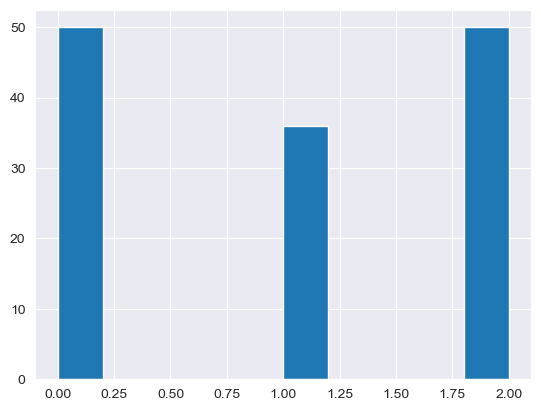

In [3]:
data["class"].hist()

<AxesSubplot:>

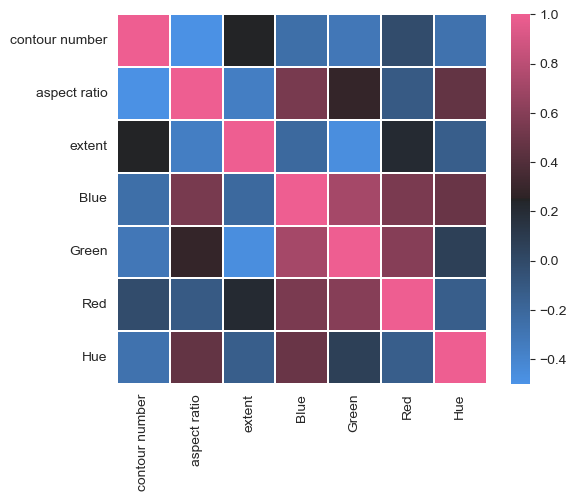

In [4]:
corr = data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

In [5]:
#data = data[['contour number', 'aspect ratio', 'extent', 'Blue', 'Green', 'Red', 'Hue', 'class']]
#data.head(10)

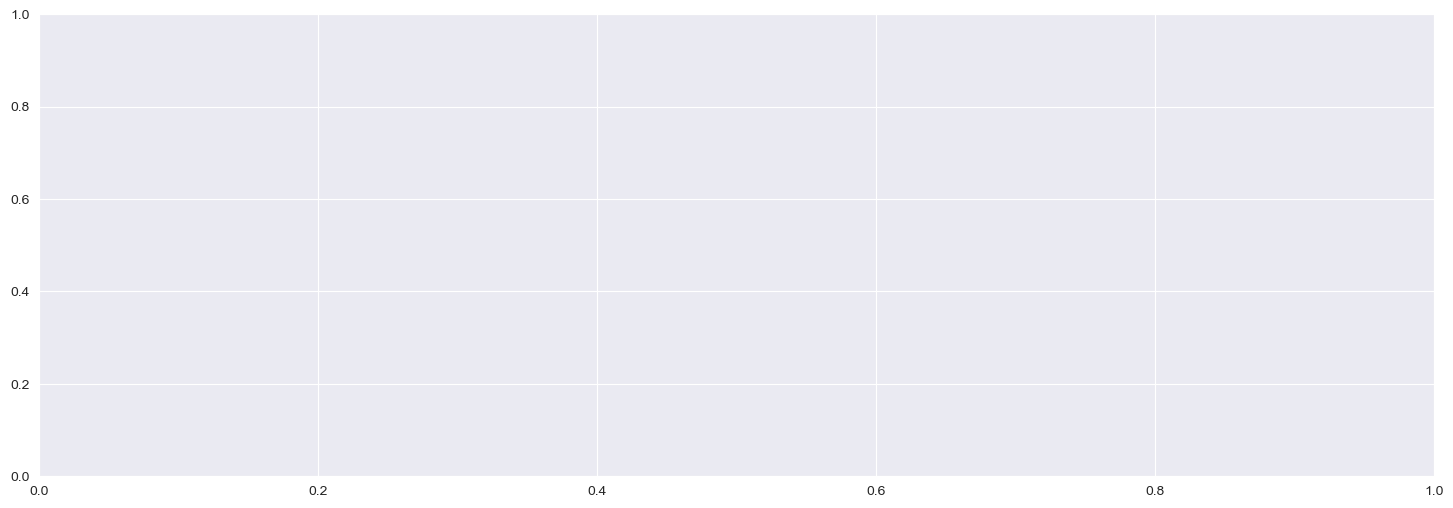

In [6]:
#print(data['contour number'])
#data_series = pd.Series([28, 68, 51, 31, 50, 56, 56, 41, 31, 36])
fig, axes = plt.subplots(1, 1, figsize=(18, 6), sharey=True)
#sns.histplot(data_series, kde=True, color='r', ax=axes[0])

#sns.histplot(data['contour number'], kde=True, color='r')

# contour_numbers = data['contour number'].values
# sns.histplot(contour_numbers, kde=True, color='r')

# fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
# sns.histplot(data, ax=axes[0], x='contour number', kde=True, color='r')
# sns.histplot(data, ax=axes[1], x='aspect ratio', kde=True, color='b')
# sns.histplot(data, ax=axes[2], x='extent', kde=True)
# sns.histplot(data, ax=axes[2], x='Blue', kde=True)
# sns.histplot(data, ax=axes[2], x='Green', kde=True)
# sns.histplot(data, ax=axes[2], x='Red', kde=True)
# sns.histplot(data, ax=axes[2], x='Hue', kde=True)





## Calculate P(Y=y) for all possible y

In [7]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

## Approach 1: Calculate P(X=x|Y=y) using Gaussian dist.

In [8]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

## Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum

In [9]:
def naive_bayes_gaussian(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

## Test Gaussian model

In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="class")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred, average='weighted'))

[[11  0  0]
 [ 0  6  0]
 [ 2  0  9]]
0.9279761904761905


In [11]:
print(data.columns)


Index(['contour number', 'aspect ratio', 'extent', 'Blue', 'Green', 'Red',
       'Hue', 'class'],
      dtype='object')


## Convert continuous features to Categorical features

In [12]:
data["cat_contour_number"] = pd.cut(data["contour number"].values, bins = 3, labels = [0,1,2])
data["cat_aspect_ratio"] = pd.cut(data["aspect ratio"].values, bins = 3, labels = [0,1,2])
data["cat_extent"] = pd.cut(data["extent"].values, bins = 3, labels = [0,1,2])
data["cat_Blue"] = pd.cut(data["Blue"].values, bins = 3, labels = [0,1,2])
data["cat_Green"] = pd.cut(data["Green"].values, bins = 3, labels = [0,1,2])
data["cat_Red"] = pd.cut(data["Red"].values, bins = 3, labels = [0,1,2])
data["cat_Hue"] = pd.cut(data["Hue"].values, bins = 3, labels = [0,1,2])

data = data.drop(columns=["contour number", "aspect ratio", "extent", "Blue", "Green", "Red", "Hue"])
data = data[["cat_contour_number",	"cat_aspect_ratio",	"cat_extent", "cat_Blue", "cat_Green", "cat_Red", "cat_Hue", "class"]]
data.head(10)


,cat_contour_number,cat_aspect_ratio,cat_extent,cat_Blue,cat_Green,cat_Red,cat_Hue,class
0,0,2,1,1,0,1,0,0
1,1,2,2,2,0,1,1,0
2,1,2,2,2,0,1,2,0
3,0,2,1,1,1,2,1,0
4,1,2,2,2,0,1,2,0
5,1,2,2,1,0,1,1,0
6,1,2,1,1,1,1,0,0
7,0,2,1,1,0,1,1,0
8,1,1,1,1,1,1,0,0
9,1,2,1,1,0,1,1,0


## Approach 2: Calculate P(X=x|Y=y) categorically

In [13]:
def calculate_likelihood_categorical(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    p_x_given_y = len(df[df[feat_name]==feat_val]) / len(df)
    return p_x_given_y

## Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum

In [14]:
def naive_bayes_categorical(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_categorical(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

## Test Categorical model

In [17]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_categorical(train, X=X_test, Y="class")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred, average='weighted'))

[[9 0 2]
 [0 6 0]
 [3 0 8]]
0.8210588583259391
